<a href="https://colab.research.google.com/github/janilitsa/gitdagray/blob/main/FFN_project3_141.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import copy
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from IPython import display
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [39]:
#      https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

#z-score all columns
data = (data - data.mean())/data.std(ddof=1)
dataOrig = copy.deepcopy(data)


In [40]:
n2nan = 10

# pick random rows to set to nan
whichVals2nan = np.random.choice(range(len(data)),size=n2nan)
data['residual sugar'][whichVals2nan] = np.nan

whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 146  171  758 1093 1104 1159 1202 1207 1347 1412]
[ 146  171  758 1093 1104 1159 1202 1207 1347 1412]


In [41]:
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

train_dataT = torch.tensor(data[cols2keep].values).float()
train_dataT = train_dataT[whichValsNotNan,:]
train_labelT = torch.tensor(data['residual sugar'].values).float()
train_labelT = train_labelT[whichValsNotNan,None]

test_dataT = torch.tensor(dataOrig[cols2keep].values).float()
test_dataT = test_dataT[whichVals2nan,:]
test_labelT = torch.tensor(dataOrig['residual sugar'].values).float()
test_labelT = test_labelT[whichVals2nan,None]

print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'   Test  data: {test_dataT.shape}\n')
print(f'   Test  data: {test_labelT.shape}\n')

Original data: (1599, 12)

   Train data: torch.Size([1589, 11])

 Train labels: torch.Size([1589, 1])

   Test  data: torch.Size([10, 11])

   Test  data: torch.Size([10, 1])



In [42]:
train_dataDataset = TensorDataset(train_dataT,train_labelT)
batchsize = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)


In [43]:
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11,16) # input layer
    self.fc1 = nn.Linear(16,32) # hidden layer
    self.fc2 = nn.Linear(32,32) # hidden layer
    self.output = nn.Linear(32,1)  # output layer                           )

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.output(x)

In [44]:
numepochs = 400

def trainTheModel():
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)
  trainLoss = torch.zeros(numepochs)
  for epochi in range(numepochs):
    batchLoss = []
    for X,y in train_data:
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss .append(loss.item())
    # end of batch loop
    trainLoss[epochi] = np.mean(batchLoss)
  return trainLoss

In [45]:
winenet = ANNwine()
trainLoss = trainTheModel()


In [46]:
yHatTrain = winenet(train_dataT)
yHatTest = winenet(test_dataT)


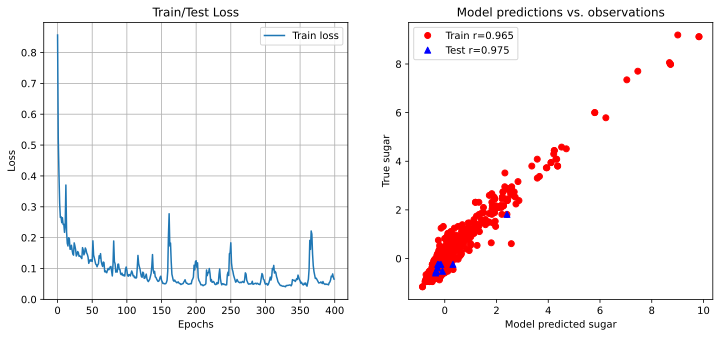

In [47]:
fig,ax = plt.subplots(1,2,figsize= (12,5))
ax[0].plot(trainLoss,label='Train loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train/Test Loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(yHatTrain.detach(),train_labelT,'ro')
ax[1].plot(yHatTest.detach(),test_labelT,'b^')
ax[1].set_xlabel('Model predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T,test_labelT.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}'])

plt.show()